**Helena Boin Gaidys**

# Exercício COVID-19
Na pasta `data/covid`encontram-se dois arquivos, sendo:
* `dados-covid-200518.csv` arquivo de dados baixado de http://plataforma.saude.gov.br/coronavirus/dados-abertos/ atualizado em 18/05/2020 com os casos detalhados da doença reportados ao SUS no Brasil;
* `dicionario-dados-covid.pdf` dicionário de dados com a descrição dos campos do arquivo de dados.

__Utilizando o Spark para leitura e tratamento dos dados, responda às seguintes perguntas:__
* Analise o número de casos e mortes (absoluto e percentual) por raça, faixa etária e escolaridade. Quais suas conclusões?
* Analise os sitomas reportados identificando os sintomas mais comuns para os que se curaram e os que morreram. Existe diferença? Quais suas conclusões?
* Qual é o perfil da população mais suscetível à morte, considerando faixa etária, escolaridade, região do país e fatores de risco? Quais suas conclusões?

__Importante__
* Utilize __apenas__ o spark para a leitura e todo o tratamento e manipulação dos dados;
* Você pode retornar os resultados do spark para a construção (opcional) de gráficos;
* A data da entrega do exercício será no dia __19/06/2020__ por e-mail para `donaldn@insper.edu.br`.

__Dicas__
* Na pasta `data/material_apoio` você encontra um Cheat Sheet do PySpark com um resumo dos comandos mais utilizados.

In [1]:
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

# Iniciando o Spark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder \
        .master('local[8]') \
        .appName('Exercício covid - Helena')\
        .getOrCreate()

In [5]:
spark

# Lendo os dados

In [6]:
datapath = "../data/covid/"

In [7]:
datafile = "dados-covid-200518.csv"

In [8]:
dados = spark.read.option("delimiter", ";").csv(datapath + datafile, header = True)

In [9]:
dados.columns

['DT_NOTIFIC',
 'SEM_NOT',
 'DT_SIN_PRI',
 'SEM_PRI',
 'SG_UF_NOT',
 'ID_REGIONA',
 'CO_REGIONA',
 'ID_MUNICIP',
 'CO_MUN_NOT',
 'ID_UNIDADE',
 'CO_UNI_NOT',
 'CS_SEXO',
 'DT_NASC',
 'NU_IDADE_N',
 'TP_IDADE',
 'COD_IDADE',
 'CS_GESTANT',
 'CS_RACA',
 'CS_ETINIA',
 'CS_ESCOL_N',
 'ID_PAIS',
 'CO_PAIS',
 'SG_UF',
 'ID_RG_RESI',
 'CO_RG_RESI',
 'ID_MN_RESI',
 'CO_MUN_RES',
 'CS_ZONA',
 'SURTO_SG',
 'NOSOCOMIAL',
 'AVE_SUINO',
 'FEBRE',
 'TOSSE',
 'GARGANTA',
 'DISPNEIA',
 'DESC_RESP',
 'SATURACAO',
 'DIARREIA',
 'VOMITO',
 'OUTRO_SIN',
 'OUTRO_DES',
 'PUERPERA',
 'CARDIOPATI',
 'HEMATOLOGI',
 'SIND_DOWN',
 'HEPATICA',
 'ASMA',
 'DIABETES',
 'NEUROLOGIC',
 'PNEUMOPATI',
 'IMUNODEPRE',
 'RENAL',
 'OBESIDADE',
 'OBES_IMC',
 'OUT_MORBI',
 'MORB_DESC',
 'VACINA',
 'DT_UT_DOSE',
 'MAE_VAC',
 'DT_VAC_MAE',
 'M_AMAMENTA',
 'DT_DOSEUNI',
 'DT_1_DOSE',
 'DT_2_DOSE',
 'ANTIVIRAL',
 'TP_ANTIVIR',
 'OUT_ANTIV',
 'DT_ANTIVIR',
 'HOSPITAL',
 'DT_INTERNA',
 'SG_UF_INTE',
 'ID_RG_INTE',
 'CO_RG_INTE',
 '

# Análise por raça, faixa etária e escolaridade

In [10]:
columns = ['NU_IDADE_N', 'TP_IDADE', 'CS_RACA', 'CS_ESCOL_N', 'CLASSI_FIN', 'EVOLUCAO']

In [11]:
sdf = dados.select(*columns)

In [12]:
sdf.show(2)

+----------+--------+-------+----------+----------+--------+
|NU_IDADE_N|TP_IDADE|CS_RACA|CS_ESCOL_N|CLASSI_FIN|EVOLUCAO|
+----------+--------+-------+----------+----------+--------+
|        43|       3|      4|         2|         4|       1|
|         3|       2|   null|      null|         2|    null|
+----------+--------+-------+----------+----------+--------+
only showing top 2 rows



In [13]:
sdf.createOrReplaceTempView('sdf3')

## Faixa Etária

In [14]:
covid_idade = spark.sql("""

            SELECT 
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                    END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS evolucao,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage

            FROM sdf3
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY faixa_idade, evolucao
            ORDER BY faixa_idade
            

            """)

In [15]:
covid_idade.show(40)

+---------------+--------+-----+-----+----------+
|    faixa_idade|evolucao|count|total|percentage|
+---------------+--------+-----+-----+----------+
|        < 1 ano|   Óbito|    1| 9166|      0.01|
|        < 1 ano|    Cura|    4| 9166|      0.04|
| De 1 a 10 anos|   Óbito|    4| 9166|      0.04|
| De 1 a 10 anos|    Cura|   30| 9166|      0.33|
|De 11 a 17 anos|   Óbito|    8| 9166|      0.09|
|De 11 a 17 anos|    Cura|   39| 9166|      0.43|
|De 18 a 29 anos|   Óbito|   61| 9166|      0.67|
|De 18 a 29 anos|    Cura|  407| 9166|      4.44|
|De 30 a 39 anos|    Cura|  979| 9166|     10.68|
|De 30 a 39 anos|   Óbito|  165| 9166|       1.8|
|De 40 a 49 anos|    Cura| 1212| 9166|     13.22|
|De 40 a 49 anos|   Óbito|  355| 9166|      3.87|
|De 50 a 59 anos|    Cura| 1222| 9166|     13.33|
|De 50 a 59 anos|   Óbito|  617| 9166|      6.73|
|De 60 a 69 anos|   Óbito|  922| 9166|     10.06|
|De 60 a 69 anos|    Cura|  779| 9166|       8.5|
|De 70 a 79 anos|   Óbito|  906| 9166|      9.88|


In [16]:
covid_idade2 = spark.sql("""

            SELECT 
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                    END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage

            FROM sdf3
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY faixa_idade
            ORDER BY percentage DESC
            

            """)

In [17]:
covid_idade2.show(40)

+---------------+-----+-----+----------+
|    faixa_idade|count|total|percentage|
+---------------+-----+-----+----------+
|De 50 a 59 anos| 1839| 9166|     20.06|
|De 60 a 69 anos| 1701| 9166|     18.56|
|De 40 a 49 anos| 1567| 9166|      17.1|
|De 70 a 79 anos| 1314| 9166|     14.34|
|De 30 a 39 anos| 1144| 9166|     12.48|
|   De 80 anos +| 1047| 9166|     11.42|
|De 18 a 29 anos|  468| 9166|      5.11|
|De 11 a 17 anos|   47| 9166|      0.51|
| De 1 a 10 anos|   34| 9166|      0.37|
|        < 1 ano|    5| 9166|      0.05|
+---------------+-----+-----+----------+



In [18]:
df_idade = covid_idade.toPandas()

In [19]:
df_idade2 = covid_idade2.toPandas()

## Raça

In [20]:
covid_raca = spark.sql("""

            SELECT 
            
            CASE
                WHEN CS_RACA = 1 THEN "Branca"
                WHEN CS_RACA = 2 THEN "Preta"
                WHEN CS_RACA = 3 THEN "Amarela"
                WHEN CS_RACA = 4 THEN "Parda"
                WHEN CS_RACA = 5 THEN "Indígena"
                ELSE "Ignorado"
            END AS raca,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS evolucao,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage

            FROM sdf3
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY raca, evolucao
            ORDER BY percentage DESC

            """)

In [21]:
covid_raca2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN CS_RACA = 1 THEN "Branca"
                WHEN CS_RACA = 2 THEN "Preta"
                WHEN CS_RACA = 3 THEN "Amarela"
                WHEN CS_RACA = 4 THEN "Parda"
                WHEN CS_RACA = 5 THEN "Indígena"
                ELSE "Ignorado"
            END AS raca,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage

            FROM sdf3
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY raca
            ORDER BY percentage DESC

            """)

In [22]:
covid_raca2.show(40)

+--------+-----+-----+----------+
|    raca|count|total|percentage|
+--------+-----+-----+----------+
|  Branca| 4808| 9166|     52.45|
|   Parda| 3540| 9166|     38.62|
|   Preta|  666| 9166|      7.27|
| Amarela|  130| 9166|      1.42|
|Indígena|   22| 9166|      0.24|
+--------+-----+-----+----------+



In [23]:
covid_raca.show(40)

+--------+--------+-----+-----+----------+
|    raca|evolucao|count|total|percentage|
+--------+--------+-----+-----+----------+
|  Branca|    Cura| 3193| 9166|     34.84|
|   Parda|   Óbito| 1881| 9166|     20.52|
|   Parda|    Cura| 1659| 9166|      18.1|
|  Branca|   Óbito| 1615| 9166|     17.62|
|   Preta|    Cura|  378| 9166|      4.12|
|   Preta|   Óbito|  288| 9166|      3.14|
| Amarela|    Cura|   71| 9166|      0.77|
| Amarela|   Óbito|   59| 9166|      0.64|
|Indígena|   Óbito|   15| 9166|      0.16|
|Indígena|    Cura|    7| 9166|      0.08|
+--------+--------+-----+-----+----------+



In [24]:
df_raca = covid_raca.toPandas()

In [25]:
df_raca2 = covid_raca2.toPandas()

## Escolaridade

In [26]:
covid_escol = spark.sql("""

            SELECT 
            
             CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1º ciclo"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2º ciclo"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS evolucao,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage

            FROM sdf3
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            
            GROUP BY escolaridade, evolucao
            ORDER BY escolaridade
            

            """)

In [27]:
covid_escol.show(20)

+--------------------+--------+-----+-----+----------+
|        escolaridade|evolucao|count|total|percentage|
+--------------------+--------+-----+-----+----------+
|0 - Sem escolaridade|    Cura|  148| 9166|      1.61|
|0 - Sem escolaridade|   Óbito|  370| 9166|      4.04|
|1 - Fundamental 1...|   Óbito| 1192| 9166|      13.0|
|1 - Fundamental 1...|    Cura|  824| 9166|      8.99|
|2 - Fundamental 2...|    Cura|  827| 9166|      9.02|
|2 - Fundamental 2...|   Óbito|  764| 9166|      8.34|
|           3 - Médio|   Óbito| 1100| 9166|      12.0|
|           3 - Médio|    Cura| 2031| 9166|     22.16|
|        4 - Superior|    Cura| 1478| 9166|     16.12|
|        4 - Superior|   Óbito|  432| 9166|      4.71|
+--------------------+--------+-----+-----+----------+



In [28]:
covid_escol2 = spark.sql("""

            SELECT 
            
             CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1º ciclo"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2º ciclo"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage

            FROM sdf3
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            
            GROUP BY escolaridade
            ORDER BY percentage DESC
            

            """)

In [29]:
df_escol = covid_escol.toPandas()

In [30]:
df_escol2 = covid_escol2.toPandas()

## Gráficos e análise

Text(0.5, 1.0, 'Proporção da amostra com covid-19 por nível de escolaridade')

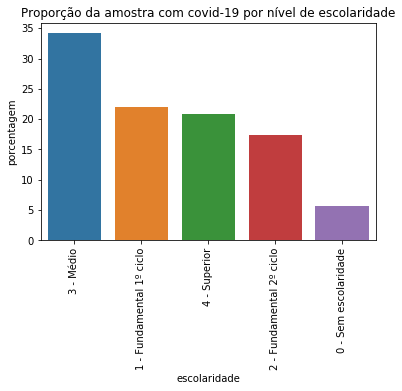

In [31]:
sns.barplot(x='escolaridade', y='percentage', data=df_escol2)
plt.xticks(rotation=90)
plt.ylabel('porcentagem')
plt.xlabel('escolaridade')
plt.title("Proporção da amostra com covid-19 por nível de escolaridade")

Text(0.5, 1.0, 'Proporção da amostra com covid-19 por faixa etária')

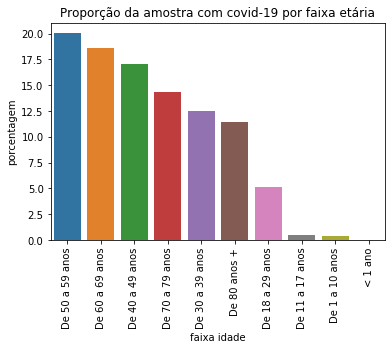

In [32]:
sns.barplot(x='faixa_idade', y='percentage', data=df_idade2)
plt.xticks(rotation=90)
plt.ylabel('porcentagem')
plt.xlabel('faixa idade')
plt.title("Proporção da amostra com covid-19 por faixa etária")


Text(0.5, 1.0, 'Proporção da amostra com covid-19 por raça')

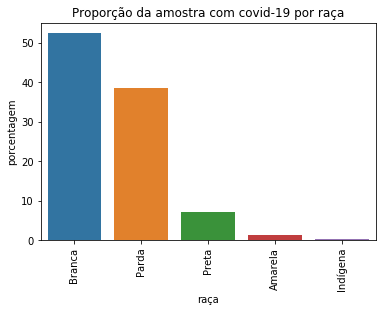

In [33]:
sns.barplot(x='raca', y='percentage', data=df_raca2)
plt.xticks(rotation=90)
plt.ylabel('porcentagem')
plt.xlabel('raça')
plt.title("Proporção da amostra com covid-19 por raça")

A maioria das pessoas contaminadas na amostra estão no ensino médio, são brancas, e estão na faixa de 50 a 59 anos. Porém, como não se tem dados da população, não dá para saber se a maioria das pessoas contaminadas se deve ao grupo ser a maioria da população, ou se esse grupo está mais vulnerável à doença.

Text(0.5, 1.0, 'Proporção da amostra com covid-19 por raça, dividido pela evolução do caso')

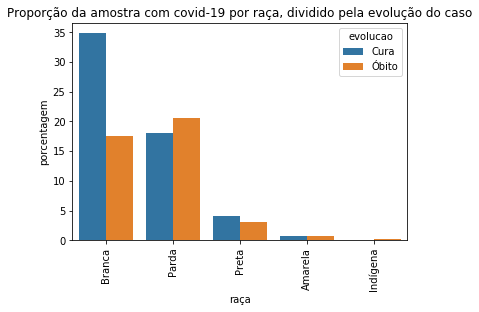

In [34]:
sns.barplot(x='raca', y='percentage', hue='evolucao', data=df_raca)
plt.xticks(rotation=90)
plt.ylabel('porcentagem')
plt.xlabel('raça')
plt.title("Proporção da amostra com covid-19 por raça, dividido pela evolução do caso")

Na amostra, a proporção de pessoas brancas que se contaminaram e sobreviveram é maior do que as que morreram. Já entre os pardos, a proporção de pessoas que morreram é maior do que as que sobreviveram. Para as demais raças, não há uma diferença relevante.

Text(0.5, 1.0, 'Proporção da amostra com covid-19 por faixa etária, dividido pela evolução do caso')

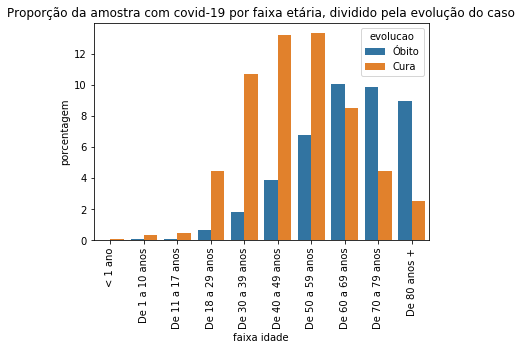

In [35]:
sns.barplot(x='faixa_idade', y='percentage', hue='evolucao', data=df_idade)
plt.xticks(rotation=90)
plt.ylabel('porcentagem')
plt.xlabel('faixa idade')
plt.title("Proporção da amostra com covid-19 por faixa etária, dividido pela evolução do caso")

Pessoas mais jovens têm maior tendência a sobreviver que pessoas mais velhas.

Text(0.5, 1.0, 'Proporção da amostra com covid-19 por nível de escolaridade, dividido pela evolução do caso')

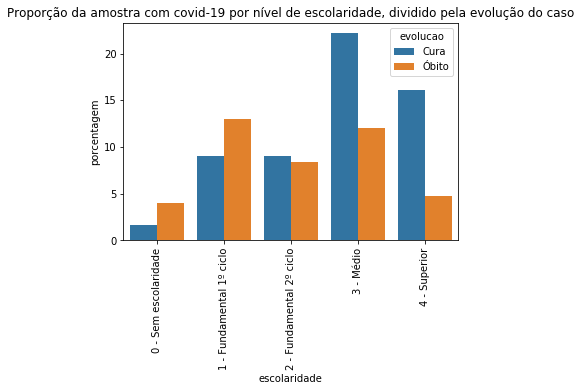

In [36]:
sns.barplot(x='escolaridade', y='percentage', hue='evolucao', data=df_escol)
plt.xticks(rotation=90)
plt.ylabel('porcentagem')
plt.xlabel('escolaridade')
plt.title("Proporção da amostra com covid-19 por nível de escolaridade, dividido pela evolução do caso")

Conforme o nível de escolaridade aumenta, a proporção de curados aumenta. Isso poderia significar, talvez, uma relação entre nível de escolaridade e renda. Com a renda maior, o paciente tem acesso à hospitais melhores, o que poderia aumentar a chance de cura. No entanto, não é possível afirmar com certeza, pois não temos acesso à população, nem à taxa de mortalidade entre hospitais.

## Combinando os dados

In [37]:
spark.sql("""

            SELECT 
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "> 80 anos"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            CASE
                WHEN CS_RACA = 1 THEN "Branca"
                WHEN CS_RACA = 2 THEN "Preta"
                WHEN CS_RACA = 3 THEN "Amarela"
                WHEN CS_RACA = 4 THEN "Parda"
                WHEN CS_RACA = 5 THEN "Indígena"
                ELSE "Ignorado"
            END AS raca,
            
            CASE
                WHEN CS_ESCOL_N = 0 THEN "Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "Fundamental 1º ciclo"
                WHEN CS_ESCOL_N = 2 THEN "Fundamental 2º ciclo"
                WHEN CS_ESCOL_N = 3 THEN "Médio"
                WHEN CS_ESCOL_N = 4 THEN "Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            COUNT(*) as count,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage
            
            FROM sdf3
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY faixa_idade, raca, escolaridade
            ORDER BY percentage DESC

            """).show()

+---------------+------+--------------------+-----+----------+
|    faixa_idade|  raca|        escolaridade|count|percentage|
+---------------+------+--------------------+-----+----------+
|De 50 a 59 anos|Branca|               Médio|  351|      3.83|
|De 40 a 49 anos|Branca|               Médio|  333|      3.63|
|De 40 a 49 anos| Parda|               Médio|  305|      3.33|
|De 50 a 59 anos|Branca|            Superior|  282|      3.08|
|De 40 a 49 anos|Branca|            Superior|  277|      3.02|
|De 50 a 59 anos| Parda|               Médio|  265|      2.89|
|De 30 a 39 anos|Branca|            Superior|  260|      2.84|
|De 30 a 39 anos|Branca|               Médio|  248|      2.71|
|De 30 a 39 anos| Parda|               Médio|  238|       2.6|
|De 60 a 69 anos|Branca|Fundamental 1º ciclo|  238|       2.6|
|De 60 a 69 anos|Branca|               Médio|  236|      2.57|
|De 60 a 69 anos| Parda|Fundamental 1º ciclo|  236|      2.57|
|De 70 a 79 anos|Branca|Fundamental 1º ciclo|  227|    

A tabela acima mostra a proporção entre grupos infectados pelo COVID-19.

Podemos notar que não há um grupo predominante. A maior concentração, apesar de pequena, são entre brancos do ensino médio entre 40 e 59 anos. Esse grupo representa 7.46% da amostra. Em seguida vem os pardos do ensino médio entre 40 e 49 anos representando 3.33% da amostra.

In [38]:
idade_raca = spark.sql("""

            SELECT 
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "> 80 anos"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            CASE
                WHEN CS_RACA = 1 THEN "Branca"
                WHEN CS_RACA = 2 THEN "Preta"
                WHEN CS_RACA = 3 THEN "Amarela"
                WHEN CS_RACA = 4 THEN "Parda"
                WHEN CS_RACA = 5 THEN "Indígena"
                ELSE "Ignorado"
            END AS raca,
            
            COUNT(*) as count,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage
            
            FROM sdf3
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_RACA = 9
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY faixa_idade, raca
            ORDER BY percentage DESC

            """)

In [39]:
df_idade_raca = idade_raca.toPandas()

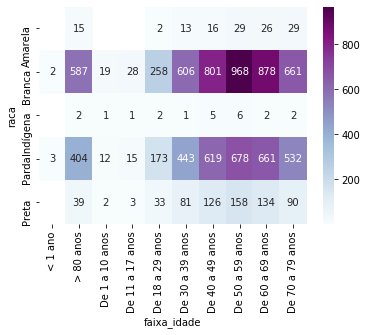

In [40]:
result = df_idade_raca.pivot(index='raca', columns='faixa_idade', values='count')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

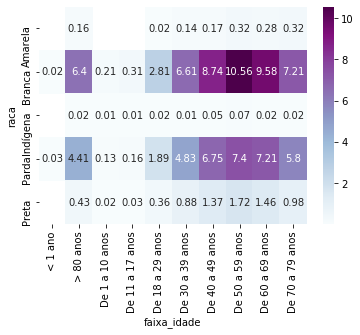

In [41]:
result = df_idade_raca.pivot(index='raca', columns='faixa_idade', values='percentage')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

O maior grupo de pessoas infectadas pelo coronavírus está entre os brancos de 50 a 59 anos, com 968 casos (10.56% da amostra). Em seguida vem os brancos de 60 a 69 anos com 878 casos (9.58% da amostra).

In [42]:
idade_escol = spark.sql("""

            SELECT 
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "> 80 anos"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,

            CASE
                WHEN CS_ESCOL_N = 0 THEN "Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "Fundamental 1º ciclo"
                WHEN CS_ESCOL_N = 2 THEN "Fundamental 2º ciclo"
                WHEN CS_ESCOL_N = 3 THEN "Médio"
                WHEN CS_ESCOL_N = 4 THEN "Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            COUNT(*) as count,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage
            
            FROM sdf3
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY faixa_idade, escolaridade
            ORDER BY percentage DESC

            """)

In [43]:
df_idade_escol = idade_escol.toPandas()

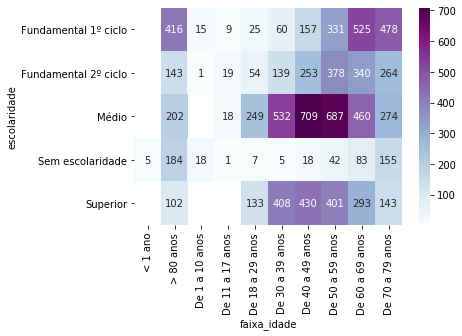

In [44]:
result = df_idade_escol.pivot(index='escolaridade', columns='faixa_idade', values='count')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

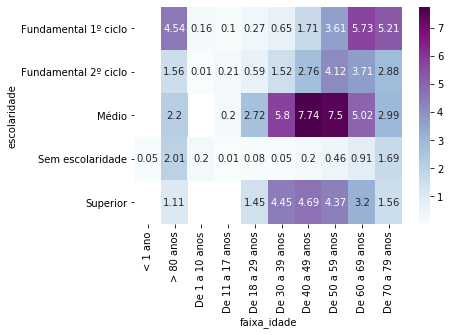

In [45]:
result = df_idade_escol.pivot(index='escolaridade', columns='faixa_idade', values='percentage')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

A maior concentração de pessoas infectadas estão no grupo de pacientes de 40 a 49 anos com nível de escolaridade até o ensino médio, com 709 casos (representando 7.74% da amostra). Em segundo lugar vem o grupo de 50 a 59 anos com nível de escolaridade até o ensino médio, com 687 casos (7.5% da amostra).

In [46]:
raca_escol = spark.sql("""

            SELECT 
            
            CASE
                WHEN CS_RACA = 1 THEN "Branca"
                WHEN CS_RACA = 2 THEN "Preta"
                WHEN CS_RACA = 3 THEN "Amarela"
                WHEN CS_RACA = 4 THEN "Parda"
                WHEN CS_RACA = 5 THEN "Indígena"
                ELSE "Ignorado"
            END AS raca,
            
            CASE
                WHEN CS_ESCOL_N = 0 THEN "Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "Fundamental 1º ciclo"
                WHEN CS_ESCOL_N = 2 THEN "Fundamental 2º ciclo"
                WHEN CS_ESCOL_N = 3 THEN "Médio"
                WHEN CS_ESCOL_N = 4 THEN "Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            COUNT(*) as count,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf3 WHERE CLASSI_FIN = 5 AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9)),
            2) AS percentage
            
            FROM sdf3
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND NOT CS_ESCOL_N >= 5
            AND NOT CS_RACA = 9
            
            GROUP BY raca, escolaridade
            ORDER BY percentage DESC

            """)

In [47]:
df_raca_escol = raca_escol.toPandas()

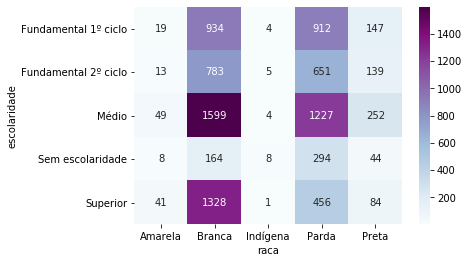

In [48]:
result = df_raca_escol.pivot(index='escolaridade', columns='raca', values='count')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

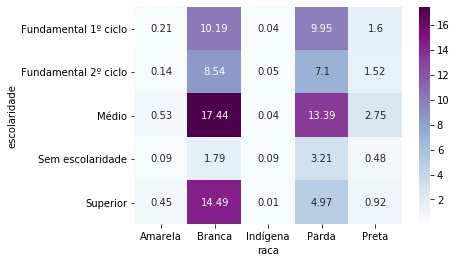

In [49]:
result = df_raca_escol.pivot(index='escolaridade', columns='raca', values='percentage')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

O principal grupo infectado são dos brancos do ensino médio, que são 17.44% da base (1599 casos). Depois vêm os brancos com ensino superior, que são 14.49% dos infectados (1328 casos).

## Conclusão

Pode-se perceber pela análise que, na amostra, pessoas mais velhas, pessoas com baixo nível de escolaridade, os pardos estão mais suscetíveis à morte. Já os jovens, com alto nível de escolaridade e brancos estão mais suscetíveis à cura.

# Análise de sintomas

In [50]:
columns1 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO',
            'DIARREIA', 'VOMITO','CLASSI_FIN', 'EVOLUCAO']

In [51]:
sdf4 = dados.select(*columns1)

In [52]:
sdf4.createOrReplaceTempView('sdf5')

## Criação das bases

In [53]:
covid_febre = spark.sql("""

            SELECT 
            
            CASE
                WHEN FEBRE = 1 THEN "Febre"
                WHEN FEBRE = 2 THEN "Sem Febre"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND FEBRE = 1
            
            GROUP BY FEBRE, EVOLUCAO
            ORDER BY count DESC
            

""")

In [54]:
covid_febre2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN FEBRE = 1 THEN "Febre"
                WHEN FEBRE = 2 THEN "Sem Febre"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND FEBRE = 1
            
            GROUP BY FEBRE, EVOLUCAO
            ORDER BY count DESC
            

""")

In [55]:
covid_febre3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN FEBRE = 1 THEN "Febre"
                WHEN FEBRE = 2 THEN "Sem Febre"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND FEBRE = 1
            
            GROUP BY FEBRE
            ORDER BY count DESC
            

""")

In [56]:
covid_tosse = spark.sql("""

            SELECT 
            
            CASE
                WHEN TOSSE = 1 THEN "Tosse"
                WHEN TOSSE = 2 THEN "Sem Tosse"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND TOSSE = 1
            
            GROUP BY TOSSE, EVOLUCAO
            ORDER BY count DESC
            

""")

In [57]:
covid_tosse2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN TOSSE = 1 THEN "Tosse"
                WHEN TOSSE = 2 THEN "Sem Tosse"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND TOSSE = 1
            
            GROUP BY TOSSE, EVOLUCAO
            ORDER BY count DESC
            

""")

In [58]:
covid_tosse3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN TOSSE = 1 THEN "Tosse"
                WHEN TOSSE = 2 THEN "Sem Tosse"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND TOSSE = 1
            
            GROUP BY TOSSE
            ORDER BY count DESC
            

""")

In [59]:
covid_garganta = spark.sql("""

            SELECT 
            
            CASE
                WHEN GARGANTA = 1 THEN "Dor de garganta"
                WHEN GARGANTA = 2 THEN "Sem dor de garganta"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND GARGANTA = 1
            
            GROUP BY GARGANTA, EVOLUCAO
            ORDER BY count DESC
            

""")

In [60]:
covid_garganta2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN GARGANTA = 1 THEN "Dor de garganta"
                WHEN GARGANTA = 2 THEN "Sem dor de garganta"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND GARGANTA = 1
            
            GROUP BY GARGANTA, EVOLUCAO
            ORDER BY count DESC
            

""")

In [61]:
covid_garganta3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN GARGANTA = 1 THEN "Dor de garganta"
                WHEN GARGANTA = 2 THEN "Sem dor de garganta"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND GARGANTA = 1
            
            GROUP BY GARGANTA
            ORDER BY count DESC
            

""")

In [62]:
covid_dispneia = spark.sql("""

            SELECT 
            
            CASE
                WHEN DISPNEIA = 1 THEN "Dispneia"
                WHEN DISPNEIA = 2 THEN "Sem dispneia"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND DISPNEIA = 1
            
            GROUP BY DISPNEIA, EVOLUCAO
            ORDER BY count DESC
            

""")

In [63]:
covid_dispneia2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN DISPNEIA = 1 THEN "Dispneia"
                WHEN DISPNEIA = 2 THEN "Sem dispneia"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND DISPNEIA = 1
            
            GROUP BY DISPNEIA, EVOLUCAO
            ORDER BY count DESC
            

""")

In [64]:
covid_dispneia3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN DISPNEIA = 1 THEN "Dispneia"
                WHEN DISPNEIA = 2 THEN "Sem dispneia"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND DISPNEIA = 1
            
            GROUP BY DISPNEIA
            ORDER BY count DESC
            

""")

In [65]:
covid_desc_resp = spark.sql("""

            SELECT 
            
            CASE
                WHEN DESC_RESP = 1 THEN "Desc. respiratório"
                WHEN DESC_RESP = 2 THEN "Sem desconforto"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND DESC_RESP = 1
            
            GROUP BY DESC_RESP, EVOLUCAO
            ORDER BY count DESC
            

""")

In [66]:
covid_desc_resp2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN DESC_RESP = 1 THEN "Desc. respiratório"
                WHEN DESC_RESP = 2 THEN "Sem desconforto"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND DESC_RESP = 1
            
            GROUP BY DESC_RESP, EVOLUCAO
            ORDER BY count DESC
            

""")

In [67]:
covid_desc_resp3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN DESC_RESP = 1 THEN "Desc. respiratório"
                WHEN DESC_RESP = 2 THEN "Sem desconforto"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND DESC_RESP = 1
            
            GROUP BY DESC_RESP
            ORDER BY count DESC
            

""")

In [68]:
covid_saturacao = spark.sql("""

            SELECT 
            
            CASE
                WHEN SATURACAO = 1 THEN "Saturação baixa"
                WHEN SATURACAO = 2 THEN "Saturação normal"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND SATURACAO = 1
            
            GROUP BY sintoma, EVOLUCAO
            ORDER BY count DESC
            

""")

In [69]:
covid_saturacao2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN SATURACAO = 1 THEN "Saturação baixa"
                WHEN SATURACAO = 2 THEN "Saturação normal"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND SATURACAO = 1
            
            GROUP BY sintoma, EVOLUCAO
            ORDER BY count DESC
            

""")

In [70]:
covid_saturacao3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN SATURACAO = 1 THEN "Saturação baixa"
                WHEN SATURACAO = 2 THEN "Saturação normal"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND SATURACAO = 1
            
            GROUP BY sintoma
            ORDER BY count DESC
            

""")

In [71]:
covid_diarreia = spark.sql("""

            SELECT 
            
            CASE
                WHEN DIARREIA = 1 THEN "Diarreia"
                WHEN DIARREIA = 2 THEN "Sem diarreia"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND DIARREIA = 1
            
            GROUP BY sintoma, EVOLUCAO
            ORDER BY count DESC
            

""")

In [72]:
covid_diarreia2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN DIARREIA = 1 THEN "Diarreia"
                WHEN DIARREIA = 2 THEN "Sem diarreia"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND DIARREIA = 1
            
            GROUP BY sintoma, EVOLUCAO
            ORDER BY count DESC
            

""")

In [73]:
covid_diarreia3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN DIARREIA = 1 THEN "Diarreia"
                WHEN DIARREIA = 2 THEN "Sem diarreia"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND DIARREIA = 1
            
            GROUP BY sintoma
            ORDER BY count DESC
            

""")

In [74]:
covid_vomito = spark.sql("""

            SELECT 
            
            CASE
                WHEN VOMITO = 1 THEN "Vomito"
                WHEN VOMITO = 2 THEN "Sem vomito"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND VOMITO = 1
            
            GROUP BY sintoma, EVOLUCAO
            ORDER BY count DESC
            

""")

In [75]:
covid_vomito2 = spark.sql("""

            SELECT 
            
            CASE
                WHEN VOMITO = 1 THEN "Vomito"
                WHEN VOMITO = 2 THEN "Sem vomito"
                ELSE "Ignorado"
            END AS sintoma,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 1)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 1
            AND VOMITO = 1
            
            GROUP BY sintoma, EVOLUCAO
            ORDER BY count DESC
            

""")

In [76]:
covid_vomito3 = spark.sql("""

            SELECT 
            
            CASE
                WHEN VOMITO = 1 THEN "Vomito"
                WHEN VOMITO = 2 THEN "Sem vomito"
                ELSE "Ignorado"
            END AS sintoma,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND NOT EVOLUCAO = 9
            AND VOMITO = 1
            
            GROUP BY sintoma
            ORDER BY count DESC
            

""")


In [77]:
spark.sql("""

            SELECT
            
            NVL(CASE
                WHEN FEBRE = 1 THEN "febre"
                WHEN TOSSE = 1 THEN "tosse"
                WHEN GARGANTA = 1 THEN "garganta"
                WHEN DISPNEIA = 1 THEN "dispneia"
                WHEN DESC_RESP = 1 THEN "desc. resp."
                WHEN SATURACAO = 1 THEN "saturação"
                WHEN DIARREIA = 1 THEN "diarreia"
                WHEN VOMITO = 1 THEN "vômito"   
            END , '---') AS sintomas,
            
            CASE
                WHEN EVOLUCAO = 1 THEN "Cura"
                WHEN EVOLUCAO = 2 THEN "Óbito"
                ELSE "Ignorado"
            END AS Evolucao,
            
            COUNT(*) AS count,
            
            (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf5 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2)),
            2) AS percentage
            
            FROM sdf5
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            
            GROUP BY sintomas, EVOLUCAO
            ORDER BY count DESC
            

""").show()

+-----------+--------+-----+-----+----------+
|   sintomas|Evolucao|count|total|percentage|
+-----------+--------+-----+-----+----------+
|      febre|   Óbito| 9627|13558|     71.01|
|      tosse|   Óbito| 1858|13558|      13.7|
|   dispneia|   Óbito| 1048|13558|      7.73|
|        ---|   Óbito|  680|13558|      5.02|
|desc. resp.|   Óbito|  206|13558|      1.52|
|  saturação|   Óbito|   85|13558|      0.63|
|   garganta|   Óbito|   36|13558|      0.27|
|     vômito|   Óbito|   11|13558|      0.08|
|   diarreia|   Óbito|    7|13558|      0.05|
+-----------+--------+-----+-----+----------+



## Frequência de sintomas

In [78]:
covid_tosse3.show()

+-------+-----+-----+----------+
|sintoma|count|total|percentage|
+-------+-----+-----+----------+
|  Tosse|23490|29993|     78.32|
+-------+-----+-----+----------+



In [79]:
covid_febre3.show()

+-------+-----+-----+----------+
|sintoma|count|total|percentage|
+-------+-----+-----+----------+
|  Febre|22727|29993|     75.77|
+-------+-----+-----+----------+



In [80]:
covid_dispneia3.show()

+--------+-----+-----+----------+
| sintoma|count|total|percentage|
+--------+-----+-----+----------+
|Dispneia|21268|29993|     70.91|
+--------+-----+-----+----------+



In [81]:
covid_desc_resp3.show()

+------------------+-----+-----+----------+
|           sintoma|count|total|percentage|
+------------------+-----+-----+----------+
|Desc. respiratório|17968|29993|     59.91|
+------------------+-----+-----+----------+



In [82]:
covid_saturacao3.show()

+---------------+-----+-----+----------+
|        sintoma|count|total|percentage|
+---------------+-----+-----+----------+
|Saturação baixa|16879|29993|     56.28|
+---------------+-----+-----+----------+



In [83]:
covid_garganta3.show()

+---------------+-----+-----+----------+
|        sintoma|count|total|percentage|
+---------------+-----+-----+----------+
|Dor de garganta| 6715|29993|     22.39|
+---------------+-----+-----+----------+



In [84]:
covid_diarreia3.show()

+--------+-----+-----+----------+
| sintoma|count|total|percentage|
+--------+-----+-----+----------+
|Diarreia| 4069|29993|     13.57|
+--------+-----+-----+----------+



In [85]:
covid_vomito3.show()

+-------+-----+-----+----------+
|sintoma|count|total|percentage|
+-------+-----+-----+----------+
| Vomito| 2317|29993|      7.73|
+-------+-----+-----+----------+



## Relacão entre os sintomas e número total de mortos

In [86]:
covid_dispneia.show(2)

+--------+--------+-----+-----+----------+
| sintoma|Evolucao|count|total|percentage|
+--------+--------+-----+-----+----------+
|Dispneia|   Óbito|10430|13558|     76.93|
+--------+--------+-----+-----+----------+



In [87]:
covid_tosse.show(2)

+-------+--------+-----+-----+----------+
|sintoma|Evolucao|count|total|percentage|
+-------+--------+-----+-----+----------+
|  Tosse|   Óbito| 9888|13558|     72.93|
+-------+--------+-----+-----+----------+



In [88]:
covid_febre.show(2)

+-------+--------+-----+-----+----------+
|sintoma|Evolucao|count|total|percentage|
+-------+--------+-----+-----+----------+
|  Febre|   Óbito| 9627|13558|     71.01|
+-------+--------+-----+-----+----------+



In [89]:
covid_saturacao.show(2)

+---------------+--------+-----+-----+----------+
|        sintoma|Evolucao|count|total|percentage|
+---------------+--------+-----+-----+----------+
|Saturação baixa|   Óbito| 9233|13558|      68.1|
+---------------+--------+-----+-----+----------+



In [90]:
covid_desc_resp.show(2)

+------------------+--------+-----+-----+----------+
|           sintoma|Evolucao|count|total|percentage|
+------------------+--------+-----+-----+----------+
|Desc. respiratório|   Óbito| 9044|13558|     66.71|
+------------------+--------+-----+-----+----------+



In [91]:
covid_garganta.show(2)

+---------------+--------+-----+-----+----------+
|        sintoma|Evolucao|count|total|percentage|
+---------------+--------+-----+-----+----------+
|Dor de garganta|   Óbito| 2459|13558|     18.14|
+---------------+--------+-----+-----+----------+



In [92]:
covid_diarreia.show(2)

+--------+--------+-----+-----+----------+
| sintoma|Evolucao|count|total|percentage|
+--------+--------+-----+-----+----------+
|Diarreia|   Óbito| 1429|13558|     10.54|
+--------+--------+-----+-----+----------+



In [93]:
covid_vomito.show(2)

+-------+--------+-----+-----+----------+
|sintoma|Evolucao|count|total|percentage|
+-------+--------+-----+-----+----------+
| Vomito|   Óbito|  879|13558|      6.48|
+-------+--------+-----+-----+----------+



## Relação entre os sintomas e número total de sobreviventes

In [94]:
covid_tosse2.show()

+-------+--------+-----+-----+----------+
|sintoma|Evolucao|count|total|percentage|
+-------+--------+-----+-----+----------+
|  Tosse|    Cura|13602|16435|     82.76|
+-------+--------+-----+-----+----------+



In [95]:
covid_febre2.show()

+-------+--------+-----+-----+----------+
|sintoma|Evolucao|count|total|percentage|
+-------+--------+-----+-----+----------+
|  Febre|    Cura|13100|16435|     79.71|
+-------+--------+-----+-----+----------+



In [96]:
covid_dispneia2.show()

+--------+--------+-----+-----+----------+
| sintoma|Evolucao|count|total|percentage|
+--------+--------+-----+-----+----------+
|Dispneia|    Cura|10838|16435|     65.94|
+--------+--------+-----+-----+----------+



In [97]:
covid_desc_resp2.show()

+------------------+--------+-----+-----+----------+
|           sintoma|Evolucao|count|total|percentage|
+------------------+--------+-----+-----+----------+
|Desc. respiratório|    Cura| 8924|16435|      54.3|
+------------------+--------+-----+-----+----------+



In [98]:
covid_saturacao2.show()

+---------------+--------+-----+-----+----------+
|        sintoma|Evolucao|count|total|percentage|
+---------------+--------+-----+-----+----------+
|Saturação baixa|    Cura| 7646|16435|     46.52|
+---------------+--------+-----+-----+----------+



In [99]:
covid_garganta2.show()

+---------------+--------+-----+-----+----------+
|        sintoma|Evolucao|count|total|percentage|
+---------------+--------+-----+-----+----------+
|Dor de garganta|    Cura| 4256|16435|      25.9|
+---------------+--------+-----+-----+----------+



In [100]:
covid_diarreia2.show()

+--------+--------+-----+-----+----------+
| sintoma|Evolucao|count|total|percentage|
+--------+--------+-----+-----+----------+
|Diarreia|    Cura| 2640|16435|     16.06|
+--------+--------+-----+-----+----------+



In [101]:
covid_vomito2.show(2)

+-------+--------+-----+-----+----------+
|sintoma|Evolucao|count|total|percentage|
+-------+--------+-----+-----+----------+
| Vomito|    Cura| 1438|16435|      8.75|
+-------+--------+-----+-----+----------+



## Conclusão

Abaixo segue, em ordem decrescente, a proporção entre o sintoma e os 43,906 casos de COVID-19:

- Tosse: 78.32%
- Febre: 75.77%
- Dispneia: 70.91%
- Desconforto respiratório: 59.91%
- Saturação de O$_{2}$ abaixo de 95%: 56.28%
- Dor de garganta: 22.39%
- Diarreia: 13.57%
- Vômito: 7.73%

Abaixo segue, em ordem decrescente, a proporção entre o sintoma e os 13,558 casos que resultaram em óbito: 

- Dispneia: 76.93%
- Tosse: 72.93%
- Febre: 71.01%
- Saturação de O$_{2}$ abaixo de 95%: 68.1%
- Desconforto respiratório: 66.71%
- Dor de garganta: 18.14%
- Diarreia: 10.54%
- Vômito: 6.48%

Abaixo segue, em ordem decrescente, a proporção entre o sintoma e os 16,435 casos que resultaram em cura:

- Tosse: 82.76%
- Febre: 79.71%
- Dispneia: 65.94%
- Desconforto respiratório: 54.3%
- Saturação de O$_{2}$ abaixo de 95%: 46.52%
- Dor de garganta: 25.9%
- Diarreia: 16.06%
- Vômito: 8.75%

Saturação de O$_{2}$, dispneia e desconforto respiratório são três sintomas que requerem atenção, pois tem a proporção maior entre os mortos do que entre os sobreviventes. O restante não parecem ser fatores de risco tão relevantes.

No entanto, seria necessário rodar algum modelo estatístico, como a regressão logística por exemplo, para avaliar quais são os sintomas relevantes para a fatalidade.

## Quantidade de sintomas vs evolução

In [102]:
covid_sintomas = spark.sql("""

        SELECT 
        
        CASE
            WHEN FEBRE = 1 THEN 1
            ELSE 0
        END AS febre,
        
        CASE
            WHEN TOSSE = 1 THEN 1
            ELSE 0
        END AS tosse,
        
        CASE
            WHEN GARGANTA = 1 THEN 1
            ELSE 0
        END AS garganta,
        
        CASE
            WHEN DISPNEIA = 1 THEN 1
            ELSE 0
        END AS dispneia,
        
        CASE
            WHEN DESC_RESP = 1 THEN 1
            ELSE 0
        END AS desc_resp,
        
        CASE
            WHEN SATURACAO = 1 THEN 1
            ELSE 0
        END AS saturacao,
        
        CASE
            WHEN DIARREIA = 1 THEN 1
            ELSE 0
        END AS diarreia,
        
        CASE
            WHEN VOMITO = 1 THEN 1
            ELSE 0
        END AS vomito,
        
        CASE
            WHEN EVOLUCAO = 1 THEN "Cura"
            WHEN EVOLUCAO = 2 THEN "Óbito"
            ELSE "Ignorado"
        END AS evolucao, 
        
        (CASE
            WHEN FEBRE = 1 THEN 1
            ELSE 0
        END +
        
        CASE
            WHEN TOSSE = 1 THEN 1
            ELSE 0
        END +
        
        CASE
            WHEN GARGANTA = 1 THEN 1
            ELSE 0
        END +
        
        CASE
            WHEN DISPNEIA = 1 THEN 1
            ELSE 0
        END +
    
        CASE
            WHEN DESC_RESP = 1 THEN 1
            ELSE 0
        END +
        
        CASE
            WHEN SATURACAO = 1 THEN 1
            ELSE 0
        END +
        
        CASE
            WHEN DIARREIA = 1 THEN 1
            ELSE 0
        END +
        
        CASE
            WHEN VOMITO = 1 THEN 1
            ELSE 0
        END) as SOMA
        FROM sdf5
        
        WHERE CLASSI_FIN = 5
        AND NOT EVOLUCAO = 9
        

""")

In [103]:
covid_sintomas.show(10)

+-----+-----+--------+--------+---------+---------+--------+------+--------+----+
|febre|tosse|garganta|dispneia|desc_resp|saturacao|diarreia|vomito|evolucao|SOMA|
+-----+-----+--------+--------+---------+---------+--------+------+--------+----+
|    1|    1|       1|       0|        0|        0|       0|     0|    Cura|   3|
|    1|    1|       0|       1|        0|        1|       1|     1|   Óbito|   6|
|    1|    1|       1|       0|        1|        0|       1|     1|    Cura|   6|
|    1|    1|       0|       1|        1|        1|       1|     0|   Óbito|   6|
|    0|    1|       0|       1|        0|        1|       0|     0|   Óbito|   3|
|    1|    0|       0|       1|        1|        1|       0|     0|   Óbito|   4|
|    1|    1|       0|       0|        0|        0|       1|     0|    Cura|   3|
|    1|    1|       0|       1|        0|        0|       0|     0|   Óbito|   3|
|    0|    0|       0|       1|        0|        1|       0|     0|    Cura|   2|
|    0|    0|   

In [104]:
covid_sintomas = covid_sintomas.select("evolucao", "soma")

In [105]:
covid_sintomas.show()

+--------+----+
|evolucao|soma|
+--------+----+
|    Cura|   3|
|   Óbito|   6|
|    Cura|   6|
|   Óbito|   6|
|   Óbito|   3|
|   Óbito|   4|
|    Cura|   3|
|   Óbito|   3|
|    Cura|   2|
|   Óbito|   3|
|    Cura|   4|
|    Cura|   6|
|    Cura|   6|
|    Cura|   2|
|    Cura|   3|
|    Cura|   6|
|   Óbito|   5|
|    Cura|   3|
|    Cura|   6|
|    Cura|   3|
+--------+----+
only showing top 20 rows



In [106]:
covid_sintomas2 = covid_sintomas.groupBy("soma", "evolucao") \
                                .count() \
                                .sort("soma", ascending = False)

In [107]:
rdd_sintomas = covid_sintomas2.rdd

In [108]:
covid_sintomas3 = rdd_sintomas.toDF()

In [109]:
covid_sintomas3.createTempView("covid_sintomas4")

In [110]:
covid_quant_sint = spark.sql("""

            SELECT *,
            
            (SELECT SUM(count) FROM covid_sintomas4) AS total,
            
            ROUND(
            100* (count / (SELECT SUM(count) FROM covid_sintomas4)),
            2) AS percentage
            
            FROM covid_sintomas4
            
            ORDER BY percentage DESC

""")

In [111]:
covid_quant_sint.show()

+----+--------+-----+-----+----------+
|soma|evolucao|count|total|percentage|
+----+--------+-----+-----+----------+
|   4|    Cura| 3818|29993|     12.73|
|   3|    Cura| 3657|29993|     12.19|
|   5|    Cura| 3336|29993|     11.12|
|   5|   Óbito| 3332|29993|     11.11|
|   4|   Óbito| 3073|29993|     10.25|
|   3|   Óbito| 2593|29993|      8.65|
|   2|    Cura| 2032|29993|      6.77|
|   6|    Cura| 1801|29993|       6.0|
|   6|   Óbito| 1721|29993|      5.74|
|   2|   Óbito| 1251|29993|      4.17|
|   1|    Cura|  809|29993|       2.7|
|   0|   Óbito|  680|29993|      2.27|
|   1|   Óbito|  505|29993|      1.68|
|   0|    Cura|  450|29993|       1.5|
|   7|    Cura|  414|29993|      1.38|
|   7|   Óbito|  299|29993|       1.0|
|   8|    Cura|  118|29993|      0.39|
|   8|   Óbito|  104|29993|      0.35|
+----+--------+-----+-----+----------+



In [112]:
df_quant_sint = covid_quant_sint.toPandas()

Text(0.5, 1.0, 'Proporção da amostra com covid-19 por quantidade de sintomas, dividido pela evolução do caso')

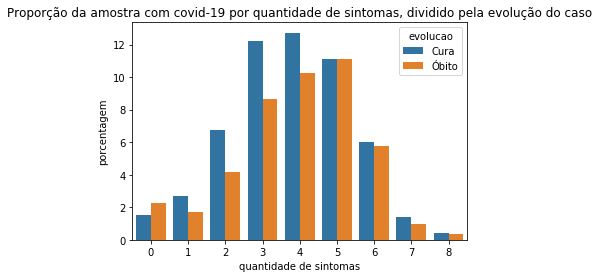

In [113]:
sns.barplot(x='soma', y='percentage', hue='evolucao', data=df_quant_sint)
plt.xticks(rotation=0)
plt.ylabel('porcentagem')
plt.xlabel('quantidade de sintomas')
plt.title("Proporção da amostra com covid-19 por quantidade de sintomas, dividido pela evolução do caso")

## Conclusão

Pode-se ver pelo gráfico acima que para quantidade de sintomas maior que zero, é maior a probabilidade de morte do que de sobrevida. Para casos sem nenhum sintoma, a probabilidade de cura é maior.

# Análise do perfil da população mais suscetível à morte

In [114]:
columns2 = ['NU_IDADE_N', 'TP_IDADE', 'CS_ESCOL_N', 'SG_UF', 'PUERPERA', 'HEMATOLOGI', 'SIND_DOWN',
           'HEPATICA', 'ASMA', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 
            'OUT_MORBI', 'EVOLUCAO', 'CLASSI_FIN']

In [115]:
sdf6 = dados.select(*columns2)

In [116]:
sdf6.createOrReplaceTempView('sdf7')

In [117]:
idade_obito = spark.sql("""
            SELECT
            
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY faixa_idade
            ORDER BY count DESC
            

""")

In [118]:
risco_obito = spark.sql("""
            SELECT
            
            NVL(CASE
                WHEN PUERPERA = 1 THEN "com fator de risco"
                WHEN HEMATOLOGI = 1 THEN "com fator de risco"
                WHEN SIND_DOWN = 1 THEN "com fator de risco"
                WHEN HEPATICA = 1 THEN "com fator de risco"
                WHEN ASMA = 1 THEN "com fator de risco"
                WHEN NEUROLOGIC = 1 THEN "com fator de risco"
                WHEN PNEUMOPATI = 1 THEN "com fator de risco"
                WHEN IMUNODEPRE = 1 THEN "com fator de risco"
                WHEN RENAL = 1 THEN "com fator de risco"
                WHEN OBESIDADE = 1 THEN "com fator de risco"
                WHEN OUT_MORBI = 1 THEN "com fator de risco"       
            END , '---') AS fator_risco,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY fator_risco
            ORDER BY count DESC
            
""")

In [119]:
escol_obito = spark.sql("""
            SELECT
            
            CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY escolaridade
            ORDER BY escolaridade
            
""")

In [120]:
uf_obito = spark.sql("""
            SELECT
            
            SG_UF AS UF,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY UF
            ORDER BY count DESC
            
""")

In [121]:
idade_obito.show()

+---------------+-----+-----+----------+
|    faixa_idade|count|total|percentage|
+---------------+-----+-----+----------+
|De 60 a 69 anos|  983| 4148|      23.7|
|De 70 a 79 anos|  966| 4148|     23.29|
|   De 80 anos +|  886| 4148|     21.36|
|De 50 a 59 anos|  662| 4148|     15.96|
|De 40 a 49 anos|  384| 4148|      9.26|
|De 30 a 39 anos|  185| 4148|      4.46|
|De 18 a 29 anos|   67| 4148|      1.62|
|De 11 a 17 anos|   10| 4148|      0.24|
| De 1 a 10 anos|    4| 4148|       0.1|
|        < 1 ano|    1| 4148|      0.02|
+---------------+-----+-----+----------+



Conforme a população vai envelhecendo, aumenta o número de mortes por coronavírus.

In [122]:
risco_obito.show()

+------------------+-----+-----+----------+
|       fator_risco|count|total|percentage|
+------------------+-----+-----+----------+
|               ---| 2075| 4148|     50.02|
|com fator de risco| 2073| 4148|     49.98|
+------------------+-----+-----+----------+



Não há diferença entre ter fator de risco e não ter para óbito de coronavírus.

In [123]:
escol_obito.show()

+--------------------+-----+-----+----------+
|        escolaridade|count|total|percentage|
+--------------------+-----+-----+----------+
|0 - Sem escolaridade|  395| 4148|      9.52|
|   1 - Fundamental 1| 1259| 4148|     30.35|
|   2 - Fundamental 2|  808| 4148|     19.48|
|           3 - Médio| 1198| 4148|     28.88|
|        4 - Superior|  488| 4148|     11.76|
+--------------------+-----+-----+----------+



A maior quantidade de mortes se concentra em pessoas que cursaram até o Fundamental 1º ciclo e pessoas que cursaram até o Ensino Médio.

In [124]:
uf_obito.show(50)

+---+-----+-----+----------+
| UF|count|total|percentage|
+---+-----+-----+----------+
| SP| 1583| 4148|     38.16|
| AM|  819| 4148|     19.74|
| RJ|  655| 4148|     15.79|
| CE|  284| 4148|      6.85|
| PA|  185| 4148|      4.46|
| PE|   92| 4148|      2.22|
| RS|   78| 4148|      1.88|
| PR|   64| 4148|      1.54|
| MG|   62| 4148|      1.49|
| MA|   56| 4148|      1.35|
| BA|   47| 4148|      1.13|
| RN|   43| 4148|      1.04|
| SC|   43| 4148|      1.04|
| ES|   24| 4148|      0.58|
| PB|   24| 4148|      0.58|
| PI|   19| 4148|      0.46|
| GO|   15| 4148|      0.36|
| MT|   15| 4148|      0.36|
| RR|    7| 4148|      0.17|
| TO|    7| 4148|      0.17|
| AL|    6| 4148|      0.14|
| MS|    5| 4148|      0.12|
| AC|    5| 4148|      0.12|
| AP|    3| 4148|      0.07|
| SE|    3| 4148|      0.07|
| DF|    3| 4148|      0.07|
| RO|    1| 4148|      0.02|
+---+-----+-----+----------+



São Paulo concentra o maior número de óbitos. Em seguida vem Amazonas e Rio de Janeiro. O restante dos Estados tem poucos casos de morte.

## Combinando os dados

In [125]:
spark.sql("""
            SELECT
            
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            NVL(CASE
                WHEN PUERPERA = 1 THEN "com fator de risco"
                WHEN HEMATOLOGI = 1 THEN "com fator de risco"
                WHEN SIND_DOWN = 1 THEN "com fator de risco"
                WHEN HEPATICA = 1 THEN "com fator de risco"
                WHEN ASMA = 1 THEN "com fator de risco"
                WHEN NEUROLOGIC = 1 THEN "com fator de risco"
                WHEN PNEUMOPATI = 1 THEN "com fator de risco"
                WHEN IMUNODEPRE = 1 THEN "com fator de risco"
                WHEN RENAL = 1 THEN "com fator de risco"
                WHEN OBESIDADE = 1 THEN "com fator de risco"
                WHEN OUT_MORBI = 1 THEN "com fator de risco"       
            END , '---') AS fator_risco,
            
            CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            SG_UF AS UF,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY faixa_idade, fator_risco, escolaridade, UF
            ORDER BY count DESC
            

""").show()

+---------------+------------------+-----------------+---+-----+-----+----------+
|    faixa_idade|       fator_risco|     escolaridade| UF|count|total|percentage|
+---------------+------------------+-----------------+---+-----+-----+----------+
|   De 80 anos +|com fator de risco|1 - Fundamental 1| SP|   98| 4148|      2.36|
|De 70 a 79 anos|com fator de risco|1 - Fundamental 1| SP|   76| 4148|      1.83|
|De 60 a 69 anos|com fator de risco|1 - Fundamental 1| SP|   72| 4148|      1.74|
|De 60 a 69 anos|               ---|1 - Fundamental 1| SP|   69| 4148|      1.66|
|De 70 a 79 anos|               ---|1 - Fundamental 1| SP|   65| 4148|      1.57|
|   De 80 anos +|com fator de risco|        3 - Médio| SP|   57| 4148|      1.37|
|   De 80 anos +|               ---|1 - Fundamental 1| SP|   50| 4148|      1.21|
|De 50 a 59 anos|               ---|        3 - Médio| SP|   50| 4148|      1.21|
|De 60 a 69 anos|com fator de risco|2 - Fundamental 2| SP|   48| 4148|      1.16|
|De 60 a 69 anos

A tabela acima mostra a proporção entre grupos que resultaram em óbito pelo COVID-19.

Não há um grupo predominante. A maior concentração, apesar de pequena, são entre idosos com grau de educação até Fundamental 1º Ciclo, com fator de risco, residindo em São Paulo. Esse grupo representa 5.93% da amostra.

In [126]:
uf_escol = spark.sql("""
            SELECT
               
            CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
            
            SG_UF AS UF,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY escolaridade, UF
            ORDER BY count DESC
            

""")

In [127]:
df_uf_escol = uf_escol.toPandas()

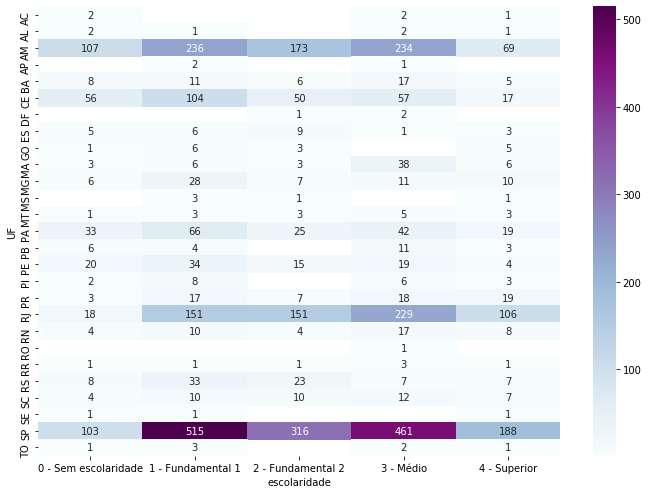

In [129]:
from matplotlib import pyplot
result = df_uf_escol.pivot(index='UF', columns='escolaridade', values='count')
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

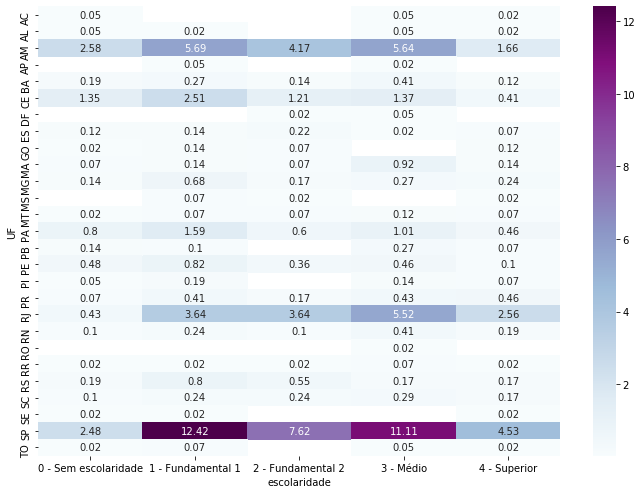

In [130]:
result = df_uf_escol.pivot(index='UF', columns='escolaridade', values='percentage')
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

Pessoas com ensino fundamental 1º ciclo completo no Estado de São Paulo são a mais suscetíveis a morte (515 casos, 12.42% da amostra). Em seguida vem pessoas com ensino médio completo no Estado de São Paulo (461 casos, 11.11% da amostra).

In [131]:
uf_risco = spark.sql("""
            SELECT
            
            NVL(CASE
                WHEN PUERPERA = 1 THEN "com fator de risco"
                WHEN HEMATOLOGI = 1 THEN "com fator de risco"
                WHEN SIND_DOWN = 1 THEN "com fator de risco"
                WHEN HEPATICA = 1 THEN "com fator de risco"
                WHEN ASMA = 1 THEN "com fator de risco"
                WHEN NEUROLOGIC = 1 THEN "com fator de risco"
                WHEN PNEUMOPATI = 1 THEN "com fator de risco"
                WHEN IMUNODEPRE = 1 THEN "com fator de risco"
                WHEN RENAL = 1 THEN "com fator de risco"
                WHEN OBESIDADE = 1 THEN "com fator de risco"
                WHEN OUT_MORBI = 1 THEN "com fator de risco"       
            END , '---') AS fator_risco,
            
            SG_UF AS UF,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY fator_risco, UF
            ORDER BY count DESC
            

""")

In [132]:
df_uf_risco = uf_risco.toPandas()

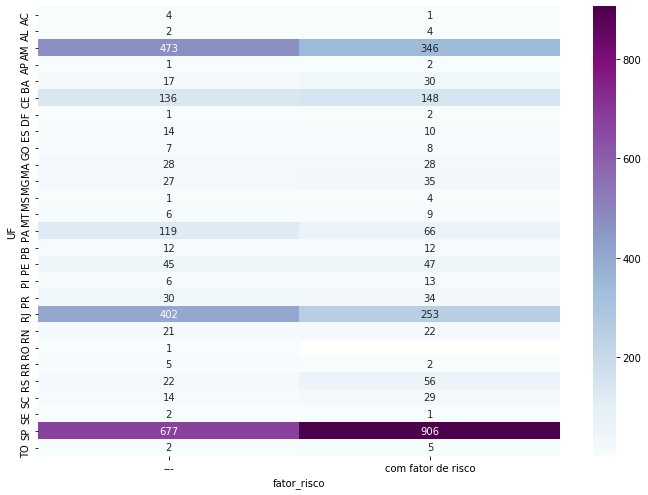

In [133]:
result = df_uf_risco.pivot(index='UF', columns='fator_risco', values='count')
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

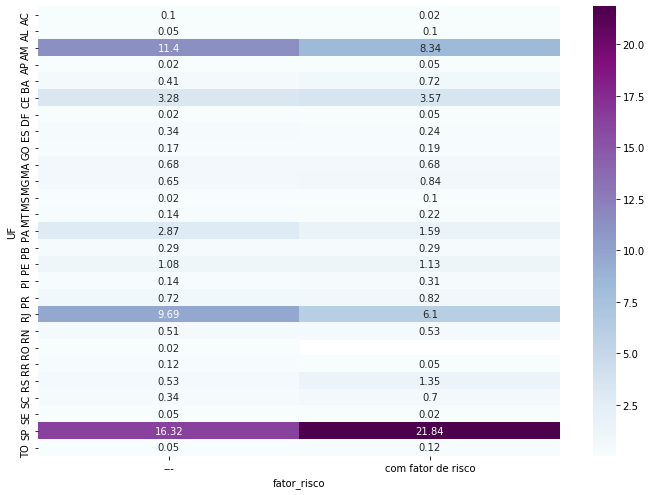

In [151]:
result = df_uf_risco.pivot(index='UF', columns='fator_risco', values='percentage')
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

Em São Paulo, pessoas com fator de risco são as mais suscetíveis à morte (906 casos, 21.84% da amostra).

In [134]:
uf_idade = spark.sql("""
            SELECT
            
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            SG_UF AS UF,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY faixa_idade, UF
            ORDER BY count DESC
            

""")

In [135]:
df_uf_idade = uf_idade.toPandas()

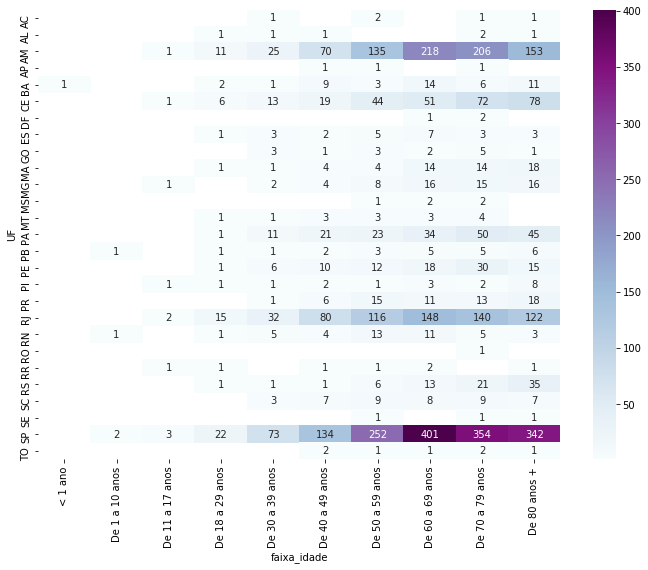

In [137]:
result = df_uf_idade.pivot(index='UF', columns='faixa_idade', values='count')
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

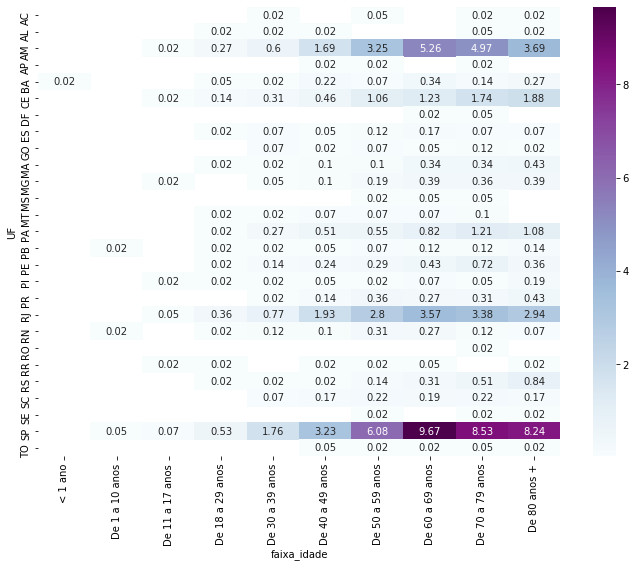

In [152]:
result = df_uf_idade.pivot(index='UF', columns='faixa_idade', values='percentage')
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

Pessoas de 60 a 69 anos residentes no Estado de São Paulo são as mais suscetíveis à morte. Representam 9.67% da amostra com 401 casos.

In [139]:
idade_risco = spark.sql("""
            SELECT
            
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,
            
            NVL(CASE
                WHEN PUERPERA = 1 THEN "com fator de risco"
                WHEN HEMATOLOGI = 1 THEN "com fator de risco"
                WHEN SIND_DOWN = 1 THEN "com fator de risco"
                WHEN HEPATICA = 1 THEN "com fator de risco"
                WHEN ASMA = 1 THEN "com fator de risco"
                WHEN NEUROLOGIC = 1 THEN "com fator de risco"
                WHEN PNEUMOPATI = 1 THEN "com fator de risco"
                WHEN IMUNODEPRE = 1 THEN "com fator de risco"
                WHEN RENAL = 1 THEN "com fator de risco"
                WHEN OBESIDADE = 1 THEN "com fator de risco"
                WHEN OUT_MORBI = 1 THEN "com fator de risco"       
            END , '---') AS fator_risco,
            
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY faixa_idade, fator_risco
            ORDER BY count DESC
            

""")

In [140]:
df_idade_risco = idade_risco.toPandas()

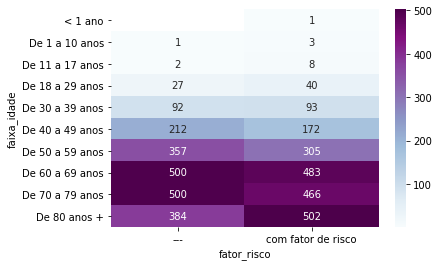

In [141]:
result = df_idade_risco.pivot(index='faixa_idade', columns='fator_risco', values='count')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

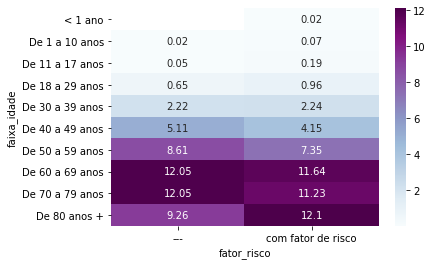

In [153]:
result = df_idade_risco.pivot(index='faixa_idade', columns='fator_risco', values='percentage')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

Pessoas com mais de 80 anos e com fator de risco são as mais suscetíveis à morte. Há 502 casos, o que é 12.1% da amostra.

In [143]:
idade_escol = spark.sql("""
            SELECT
            
            CASE
                WHEN TP_IDADE <= 2 THEN "< 1 ano"
                WHEN TP_IDADE = 3 THEN
                    CASE
                        WHEN NU_IDADE_N <= 10 THEN "De 1 a 10 anos"
                        WHEN NU_IDADE_N > 10 AND NU_IDADE_N<=17 THEN "De 11 a 17 anos"
                        WHEN NU_IDADE_N > 17 AND NU_IDADE_N<=29 THEN "De 18 a 29 anos"
                        WHEN NU_IDADE_N > 29 AND NU_IDADE_N<=39 THEN "De 30 a 39 anos"
                        WHEN NU_IDADE_N > 39 AND NU_IDADE_N<=49 THEN "De 40 a 49 anos"
                        WHEN NU_IDADE_N > 49 AND NU_IDADE_N<=59 THEN "De 50 a 59 anos"
                        WHEN NU_IDADE_N > 59 AND NU_IDADE_N<=69 THEN "De 60 a 69 anos"
                        WHEN NU_IDADE_N > 69 AND NU_IDADE_N<=79 THEN "De 70 a 79 anos"
                        WHEN NU_IDADE_N > 79 THEN "De 80 anos +"
                        ELSE "Ignorado"
                        END
                ELSE "Ignorado"
            END AS faixa_idade,

            CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
 
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY faixa_idade, escolaridade
            ORDER BY count DESC
            

""")

In [144]:
df_idade_escol = idade_escol.toPandas()

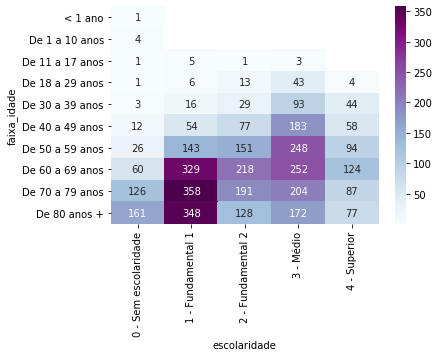

In [145]:
result = df_idade_escol.pivot(index='faixa_idade', columns='escolaridade', values='count')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

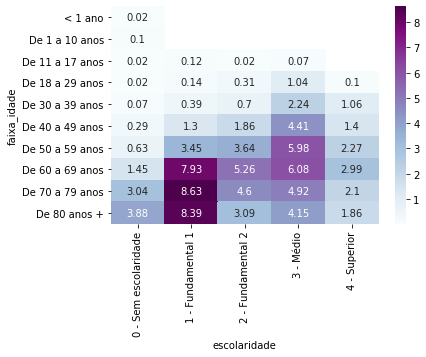

In [154]:
result = df_idade_escol.pivot(index='faixa_idade', columns='escolaridade', values='percentage')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

O grupo de pessoas com mais de 80 anos e com fundamental 1º ciclo completo é o mais suscetívei à morte. São 8.39% da amostra com 348 casos.

In [147]:
risco_escol = spark.sql("""
            SELECT
        
            NVL(CASE
                WHEN PUERPERA = 1 THEN "com fator de risco"
                WHEN HEMATOLOGI = 1 THEN "com fator de risco"
                WHEN SIND_DOWN = 1 THEN "com fator de risco"
                WHEN HEPATICA = 1 THEN "com fator de risco"
                WHEN ASMA = 1 THEN "com fator de risco"
                WHEN NEUROLOGIC = 1 THEN "com fator de risco"
                WHEN PNEUMOPATI = 1 THEN "com fator de risco"
                WHEN IMUNODEPRE = 1 THEN "com fator de risco"
                WHEN RENAL = 1 THEN "com fator de risco"
                WHEN OBESIDADE = 1 THEN "com fator de risco"
                WHEN OUT_MORBI = 1 THEN "com fator de risco"       
            END , '---') AS fator_risco,
            
            CASE
                WHEN CS_ESCOL_N = 0 THEN "0 - Sem escolaridade"
                WHEN CS_ESCOL_N = 1 THEN "1 - Fundamental 1"
                WHEN CS_ESCOL_N = 2 THEN "2 - Fundamental 2"
                WHEN CS_ESCOL_N = 3 THEN "3 - Médio"
                WHEN CS_ESCOL_N = 4 THEN "4 - Superior"
                WHEN CS_ESCOL_N = 5 THEN "Não se aplica"
                ELSE "Ignorado"
            END AS escolaridade,
    
            COUNT(*) as count,
            
            (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5) AS total,
            
            ROUND(
            100* (COUNT(*) / (SELECT COUNT(*) FROM sdf7 WHERE CLASSI_FIN = 5 AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5)),
            2) AS percentage
            
            FROM sdf7
            
            WHERE CLASSI_FIN = 5
            AND EVOLUCAO = 2
            AND NOT CS_ESCOL_N >= 5
            
            GROUP BY fator_risco, escolaridade
            ORDER BY count DESC
            

""")

In [148]:
df_risco_escol = risco_escol.toPandas()

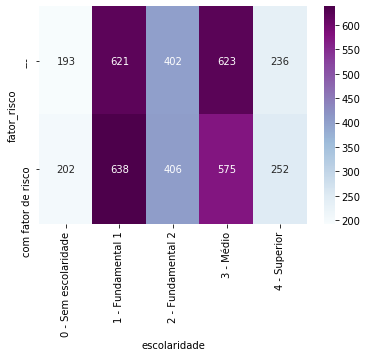

In [149]:
result = df_risco_escol.pivot(index='fator_risco', columns='escolaridade', values='count')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

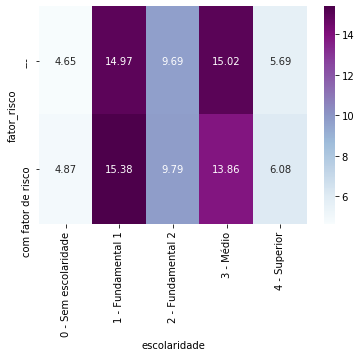

In [155]:
result = df_risco_escol.pivot(index='fator_risco', columns='escolaridade', values='percentage')
sns.heatmap(result, annot=True, fmt="g", cmap="BuPu")
plt.show()

O grupo de pessoas com fator de risco e com o fundamental 1º ciclo completo são os mais suscetíveis à morte. São 15.38% da base com 638 casos.

## Conclusão

- São Paulo é o Estado que concentra a maior quantidade de casos de óbito por COVID-19
- Pelos dados, não há uma verdadeira diferença entre ter fator de risco ou não para ser suscetível à morte
- Pessoas com menor nível de escolaridade estão mais suscetíveis ao óbito
- Pessoas mais velhas são o maior grupo de risco